## Lecture 5: Convexity (II)



In [140]:
## MP 574 Lecture 5: Convexity (II)
##
%matplotlib inline
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt
from IPython.display import display, Image
import matplotlib.image as mpimg
from os.path import dirname, join as pjoin
from scipy import signal
import scipy.io as sio
import scipy.optimize as opt
import numpy.random as rnd

font = {'weight' : 'normal',
        'size'   : 16}

In [171]:
# Some functions to optimize (one convex, one non-convex)
def function1(x,y,chooseFunction):
       
    if chooseFunction == 0:    
        # Calculate f = || x - a ||^2
        f = 8*(x-0.4)**2 + (y+2.8)**2
    
    else:
        # Calculate f = sin(2 pi x) + 1 + x^2
        f = 5 + 5*np.sin(2*np.pi*(x/2)) + 3*np.cos(2*np.pi*(y/3)) + (x-3)**2 + (y-3)**2
      
    return f

# Some constraint regions
def constraint1(x,y,chooseConstraint):
       
    if chooseConstraint == 0: 
        # No constraints
        creg = (abs(x) + abs(y)) >=0
        
    elif chooseConstraint == 1:
        # ||x||_1 < 2
        creg = (abs(x) + abs(y))<2
    
    else:
        # Some non-convex region
        center = [0,-2]
        creg1 = ((x - center[0])**2 + (y - center[1])**2) < 2.5**2
        creg2 = ((x - center[0])**2 + (y - center[1])**2) > 1.5**2
        creg = creg1 & creg2
      
    return creg



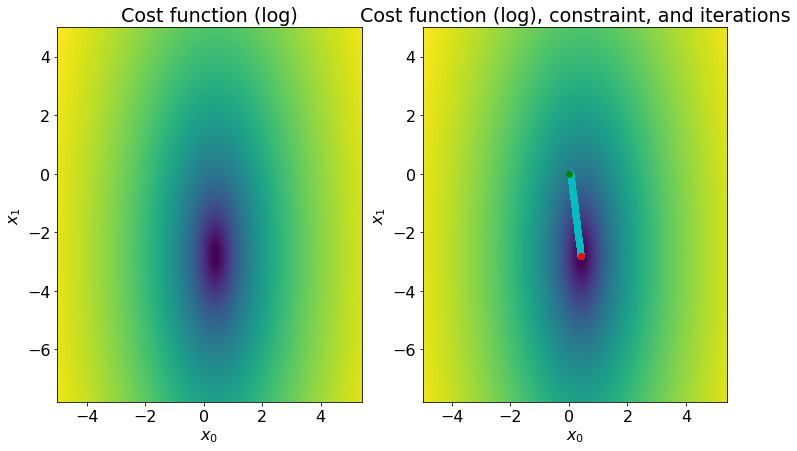

In [176]:
# Try optimizing a function defined above, with some initial guess
x0 = 0; # Initial guess
y0 = 0; # Initial guess
step = 0.01; # Step size along each direction
chooseFunction = 0; # Choice of cost function: 0 (convex), 1 (non-convex)
chooseConstraint = 0; # Choice of constraint set: 0 (no constraint), 1 (convex), 2 (non-convex)
xest = x0;
yest = y0;
fest = function1(xest,yest,chooseFunction)
cest = constraint1(xest,yest,chooseConstraint)
allx = xest
ally = yest
allf = fest
DONE = False;

if cest == False: 
    DONE = True
    print("Initial guess is not allowed (not in our constraint set)")
    
while DONE == False: # Iterate until we can no longer descend
    xtry = np.array([xest - step, xest + step, xest, xest])
    ytry = np.array([yest, yest, yest - step, yest + step])
    ftry = function1(xtry,ytry,chooseFunction)      
    ctry = constraint1(xtry,ytry,chooseConstraint) 
    ftry[ctry==False] = np.inf # Infinity of not in the constraint set
    minindex = np.argmin(ftry)
    if min(ftry) < fest:
        xest = xtry[minindex]
        yest = ytry[minindex]
        fest = ftry[minindex]
        allx = np.append(allx,xest)
        ally = np.append(ally,yest)
        allf = np.append(allf,fest)
    else: # If none of the steps decrease our function, this algorithm is done
        DONE = True
        
# Finally, plot the overall function (in grey) and our "path" (from green to red, path in cyan)        
xgrid = np.linspace(np.min(allx)-5,np.max(allx)+5,1001)
ygrid = np.linspace(np.min(ally)-5,np.max(ally)+5,1001)
X, Y = np.meshgrid(xgrid,ygrid)
fgrid = function1(X,Y,chooseFunction)
cgrid = constraint1(X,Y,chooseConstraint)

plt.figure(figsize=(12,12))
plt.rc('font', **font)
plt.subplot(1,2,1)
plt.imshow(np.log(np.flipud(fgrid) + 1), extent = [xgrid[0], xgrid[-1], ygrid[0], ygrid[-1]])
#plt.imshow(np.flipud(cgrid), extent = [xgrid[0], xgrid[-1], ygrid[0], ygrid[-1]])
plt.xlabel('$x_0$')
plt.ylabel('$x_1$');
plt.title('Cost function (log)');
        
plt.subplot(1,2,2)
plt.imshow(np.log(np.flipud(fgrid*cgrid + 1)), extent = [xgrid[0], xgrid[-1], ygrid[0], ygrid[-1]])
#plt.imshow(np.flipud(cgrid), extent = [xgrid[0], xgrid[-1], ygrid[0], ygrid[-1]])
plt.scatter(allx,ally,color='c')
plt.scatter(allx[0],ally[0],color='g')
plt.scatter(allx[-1],ally[-1],color='r')
plt.xlabel('$x_0$')
plt.ylabel('$x_1$');
plt.title('Cost function (log), constraint, and iterations');
        

## Q1: Therapy planning


Let us consider a constrained therapy planning  problem, as follows:
\begin{equation} 
\begin{array}{lll}
\mathbf{x}^* & = &  \arg \min_{\mathbf{x}} \| \mathbf{Dx} - \mathbf{d} \|_2^2 \\
& \hbox{s.t.} & \mathbf{x} \geq \mathbf{0} \\
& & \mathbf{D_s x} \leq d_{S,max} 
\end{array}
\end{equation}
where $\mathbf{D}$ is the dose deposition matrix mapping the fluence map $\mathbf{x}$ to the dose deposition, which tries to match a desired dose deposition $\mathbf{d}$. The constraints include the basic physical constraint ($\mathbf{x} \geq 0$) that the fluence needs to be non-negative, as well as the hard constraint ($\mathbf{D_s x} \leq d_{S,max}$) that the dose deposited in the spine  needs to be uniformly less than $d_{S,max}$.

*Question:* Is this constrained formulation convex? 

A: Yes, because the cost function is convex, and the constraints define a convex set

B: No, because the cost function is not convex, even though the constraints are convex

C: No, because the constraints are not convex, even though the cost function is convex

D: Depends on the choice of matrix $\mathbf{D}$ and desired dose deposition $\mathbf{d}$
